In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import dask.distributed as dsk
import matplotlib.gridspec as gs
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point
from xarrayMannKendall import *

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

clnt = dsk.Client()
clnt

Client Scheduler: tcp://127.0.0.1:38873 Dashboard: /proxy/41455/status,Cluster Workers: 4 Cores: 16 Memory: 200.00 GiB


In [2]:
iso = xr.open_dataset('~/g_e14/misc/Antarctic_isobath_1000m.nc')

In [3]:
keys = ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']

In [4]:
uas = {}
vas = {}
uas['ERA-Interim'] = xr.open_dataset('../data/uas-erai-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA-Interim'] = xr.open_dataset('../data/vas-erai-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['ERA5'] = xr.open_dataset('../data/uas-era5-monthly-1979_2015.nc')['u10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['ERA5'] = xr.open_dataset('../data/vas-era5-monthly-1979_2015.nc')['v10'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CFSR'] = xr.open_dataset('../data/uas-cfsr-monthly-1979_2015.nc')['ua'].sel(lat = slice(None, -50))
vas['CFSR'] = xr.open_dataset('../data/vas-cfsr-monthly-1979_2015.nc')['va'].sel(lat = slice(None, -50))
uas['JRA55'] = xr.open_dataset('../data/uas-jra55-monthly-1979_2015.nc')['uas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
vas['JRA55'] = xr.open_dataset('../data/vas-jra55-monthly-1979_2015.nc')['vas'].sel(lat = slice(None, -50)).sel(time = slice('1979-01-01', '2015-01-01'))
uas['CMIP6'] = xr.open_dataset('../data/uas-cmip6-monthly-1958_2015.nc')['uas'].sel(time = slice('1979-01-01', '2015-01-01'))
vas['CMIP6'] = xr.open_dataset('../data/vas-cmip6-monthly-1958_2015.nc')['vas'].sel(time = slice('1979-01-01', '2015-01-01'))

In [5]:
mask = xr.open_dataset('../data/zero_div_line_with_wap_mask.nc')['__xarray_dataarray_variable__']
hu = xr.open_dataset('~/g_e14/misc/hu-01deg.nc')['hu'].sel(yu_ocean = slice(None, -50))
land_ice_mask = xr.where(np.isnan(hu.interp(yu_ocean = np.arange(-90, -50.1, .1))), 1, np.nan).interp(yu_ocean = np.arange(-90, -50.1, .1))
land_ice_mask = land_ice_mask.rename(({'xu_ocean':'lon', 'yu_ocean':'lat'}))
land_ice_mask['_lon_adj'] = xr.where(land_ice_mask['lon'] < -180, land_ice_mask['lon'] + 360, land_ice_mask['lon'])
land_ice_mask = land_ice_mask.swap_dims({'lon': '_lon_adj'})
land_ice_mask = land_ice_mask.sel(**{'_lon_adj': sorted(land_ice_mask._lon_adj)}).drop('lon')
land_ice_mask = land_ice_mask.rename({'_lon_adj': 'lon'})

In [6]:
uas_trends = {}
vas_trends = {}
for k in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']:
    u = uas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(u, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    uas_trends[k] = MK_class.compute()
    
    v = vas[k].groupby('time.year').mean('time')
    MK_class = Mann_Kendall_test(v, 'time', coords_name = {'year':'time', 'lat':'y', 'lon':'x'})
    vas_trends[k] = MK_class.compute()

In [7]:
for k in ['ERA-Interim', 'ERA5', 'CFSR', 'JRA55', 'CMIP6']:
    uas_trends[k] = uas_trends[k].rename({'x':'lon', 'y':'lat'})
    vas_trends[k] = vas_trends[k].rename({'x':'lon', 'y':'lat'})

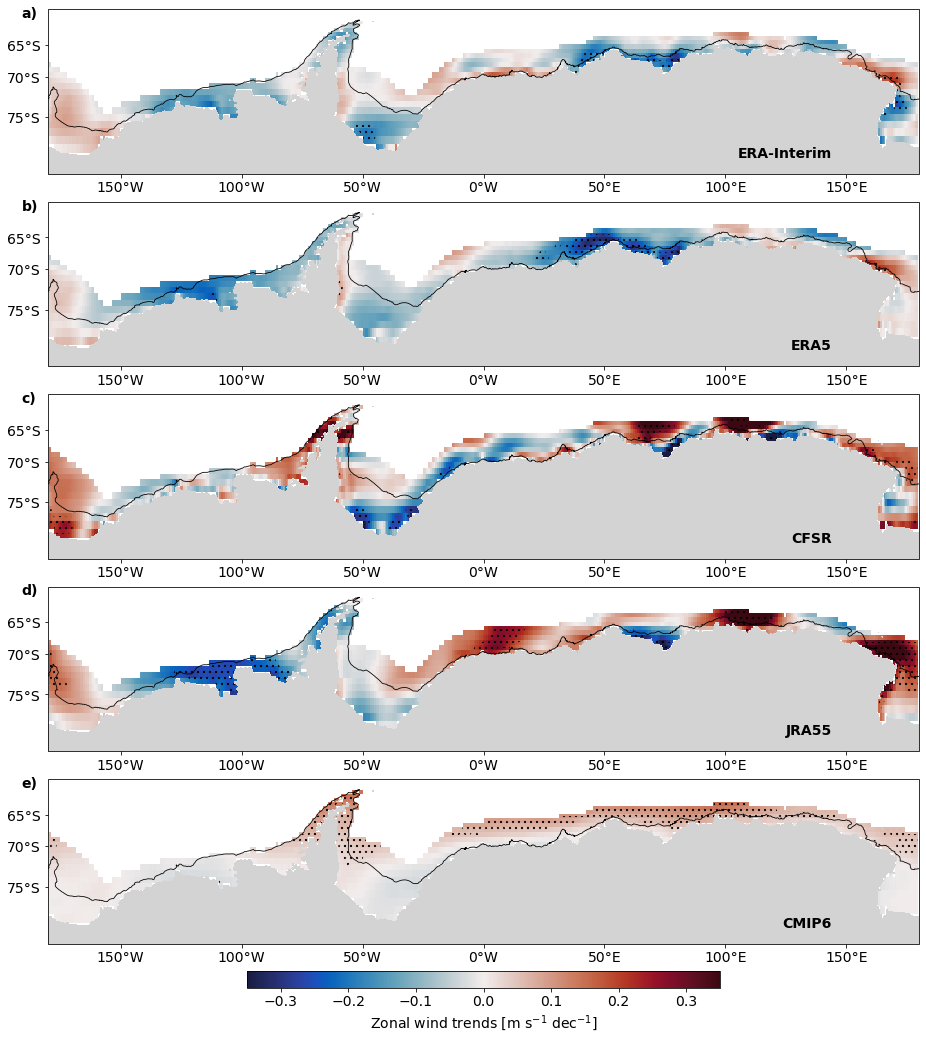

In [12]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (16, 18))
gr = gs.GridSpec(6, 3, figure = fig, height_ratios = [1, 1, 1, 1, 1, .1], width_ratios = [.2, .6, .2])
axs = [fig.add_subplot(gr[0,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[1,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[2,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[3,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[4,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[5,1])]

for ax, label, k in zip(axs[:-1], ['a)', 'b)', 'c)', 'd)', 'e)'], keys):
    
    ax.text(-0.03, .95, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.text(0.9, .1, k, transform = ax.transAxes, size = 14, weight = 'bold', horizontalalignment = 'right')
    ax.set_extent([-180, 180, -80, -58], ccrs.PlateCarree())
    ax.set_xticks(np.arange(-150, 200, 50), crs = ccrs.PlateCarree())
    ax.set_yticks(np.arange(-75, -60, 5), crs = ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label = True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'lightgrey', linewidths = 0.5, zorder = 2, transform = ccrs.PlateCarree())
   
    c = ax.pcolormesh(uas_trends[k]['lon'], uas_trends[k]['lat'], 10*uas_trends[k]['trend']*mask, cmap = cmocean.cm.balance, 
                      vmin =-.35, vmax = .35, transform = ccrs.PlateCarree())
    ax.contourf(uas_trends[k]['lon'], uas_trends[k]['lat'], uas_trends[k]['p'].where(uas_trends[k]['p'] <= .05)*mask,
                colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())
    ax.plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    
plt.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('Zonal wind trends [m s$^{-1}$ dec$^{-1}$]', fontsize = 14)
plt.savefig('../results/v2/fig2a.jpg', bbox_inches = 'tight')

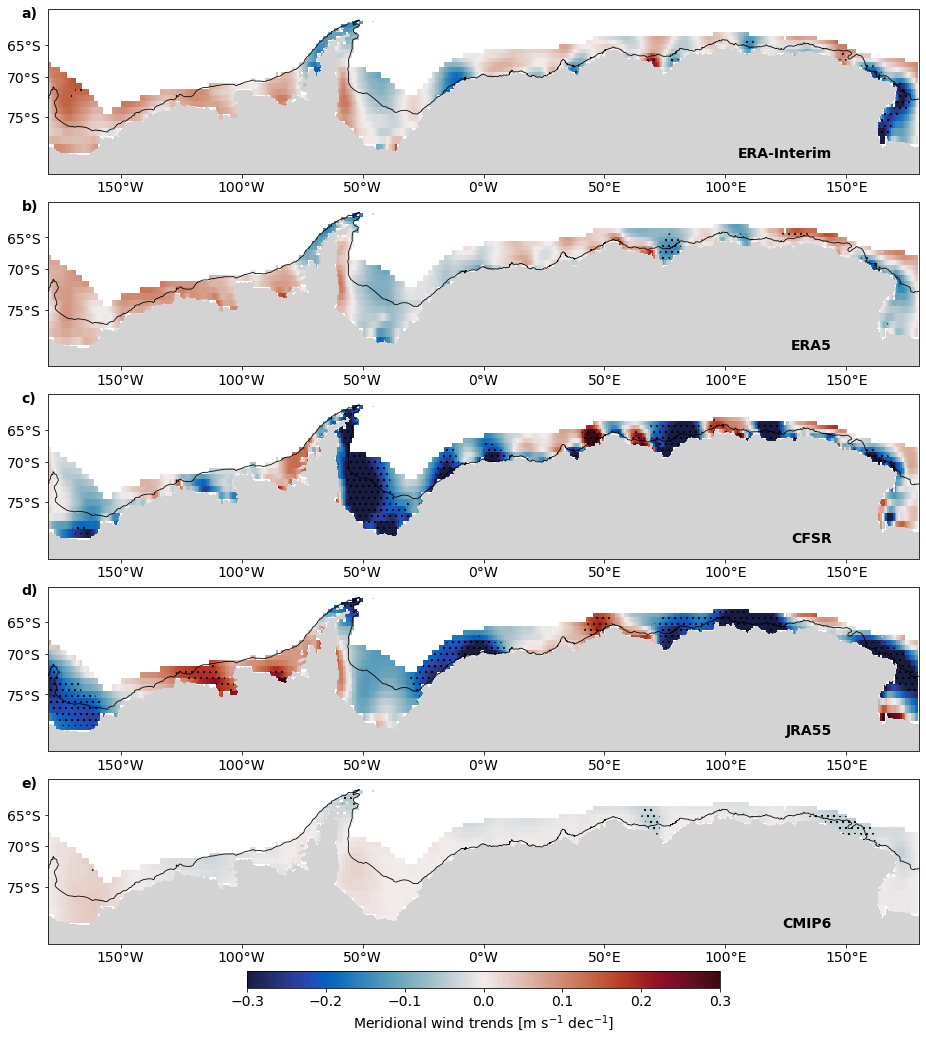

In [13]:
plt.rcParams['font.size'] = 14
fig = plt.figure(figsize = (16, 18))
gr = gs.GridSpec(6, 3, figure = fig, height_ratios = [1, 1, 1, 1, 1, .1], width_ratios = [.2, .6, .2])
axs = [fig.add_subplot(gr[0,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[1,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[2,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[3,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[4,:], projection = ccrs.Mercator(central_longitude = 0)),
       fig.add_subplot(gr[5,1])]

for ax, label, k in zip(axs[:-1], ['a)', 'b)', 'c)', 'd)', 'e)'], keys):
    
    ax.text(-0.03, .95, label, transform = ax.transAxes, size = 14, weight = 'bold')
    ax.text(0.9, .1, k, transform = ax.transAxes, size = 14, weight = 'bold', horizontalalignment = 'right')
    ax.set_extent([-180, 180, -80, -58], ccrs.PlateCarree())
    ax.set_xticks(np.arange(-150, 200, 50), crs = ccrs.PlateCarree())
    ax.set_yticks(np.arange(-75, -60, 5), crs = ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label = True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    # Land
    ax.contourf(land_ice_mask['lon'], land_ice_mask['lat'], land_ice_mask, 
                colors = 'lightgrey', linewidths = 0.5, zorder = 2, transform = ccrs.PlateCarree())
   
    c = ax.pcolormesh(vas_trends[k]['lon'], vas_trends[k]['lat'], 10*vas_trends[k]['trend']*mask, cmap = cmocean.cm.balance, 
                      vmin =-.3, vmax = .3, transform = ccrs.PlateCarree())
    ax.contourf(vas_trends[k]['lon'], vas_trends[k]['lat'], vas_trends[k]['p'].where(vas_trends[k]['p'] <= .05)*mask,
                colors = ['none'], hatches = ['..'], transform = ccrs.PlateCarree())
    ax.plot(iso['x'], iso['y'], linewidth = 0.8, color = 'k', transform = ccrs.PlateCarree())
    
plt.colorbar(c, cax = axs[-1], orientation = 'horizontal').set_label('Meridional wind trends [m s$^{-1}$ dec$^{-1}$]', fontsize = 14)
plt.savefig('../results/v2/fig2b.jpg', bbox_inches = 'tight')